In [1]:
import os
from fig_gen  import FigureGenerator as fg
from sklearn.metrics import r2_score
import pwlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
data_directory = '/work2/05067/nagyz/austin_energy/data/'
filepaths = [os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith('.csv')]
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=False)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
id_list = pd.read_csv('buildingInfo.csv')

#id_list.drop('Unnamed: 0',axis=1,inplace=True)
id_list['buildingType'].unique()
res_type = ['SINGLE FAMILY', 'MULTIFAMILY',  'FOURPLEX', 
            'DUPLEX', 'CONDOS', 'CONDO (STACKED)', 
            '1 FAM DWELLING, ACCESSORY DWELLING UNIT',
            'TOWNHOMES','MOHO SINGLE PP', 
            '1 FAM DWELLING, GARAGE APARTMENT', 'MOHO DOUBLE PP',
            'MOHO SINGLE REAL', 'MOHO DOUBLE REAL', 'TRIPLEX', 
            '1 FAM DWELLING, MOHO DOUBLE REAL',
           '1 FAM DWELLING, MOHO SINGLE REAL']
res_type_id_list = id_list[id_list['buildingType'].isin(res_type)].copy()
res_type_id_list['zipCode'].unique()

array([78759, 78758, 78757, 78756, 78754, 78753, 78752, 78751, 78750,
       78749, 78748, 78747, 78746, 78745, 78744, 78742, 78741, 78739,
       78738, 78736, 78735, 78734, 78733, 78732, 78731, 78730, 78729,
       78728, 78727, 78726, 78725, 78724, 78723, 78722, 78721, 78717,
       78705, 78704, 78703, 78702, 78701, 78660, 78653, 78652, 78617,
       78610])

In [3]:
single_Famiy=res_type_id_list[res_type_id_list['buildingType']=='SINGLE FAMILY']
single_Famiy[single_Famiy['zipCode']==78758]

,Service Point,zipCode,rate,buildingType,meterCount,squareFt
29,-1583,78758,E-SEC2,SINGLE FAMILY,14,7042.125
30,-1582,78758,E-SEC1,SINGLE FAMILY,25,19913.375
31,-1581,78758,E-RES,SINGLE FAMILY,5363,8224307.500


In [4]:
def clean_data(servicepoint):
    data=load_data(servicepoint)
    data=data.set_index(data[data.columns[0]])
    data=data[[f'{servicepoint} kWh Value']]['2018':].resample('H').sum()
    data = data.rename(columns={list(data.columns.values)[0]: 'Energy_kwh'})
    data1=data[:'2021-02-10']
    bad_value=data1[data1.columns[0]].quantile(0.98)
    #print('filter_value',bad_value)
    Index=data1[data1['Energy_kwh']>bad_value].index
    data1=data1.drop(Index)
    return pd.concat([data1,data['2021-02-11':'2021-02-22']])
def make_features(dataframe,time_level):
    s = dataframe.copy()
    if time_level!='hourly':
        example_ts = s.resample('D').mean()
    else:
        example_ts=s
    example_ts['dayofyear_cos'] = np.cos(2 * np.pi * example_ts.index.dayofyear / 365)
    example_ts['dayofyear_sim'] = np.sin(2 * np.pi * example_ts.index.dayofyear / 365)
    example_ts['month_cos'] = np.cos(2 * np.pi * example_ts.index.month / 12)
    example_ts['month_sin'] = np.sin(2 * np.pi * example_ts.index.month / 12)
    example_ts['year'] = example_ts.index.year

    if time_level == 'hourly':
        example_ts['TMP'] = weather_austin_hourl_pred.reindex(example_ts.index).values
    else:
        example_ts['TMP'] = weather_austin_daily.resample(time_level).mean().reindex(example_ts.index).values
    return example_ts

In [5]:
def preprocess_data(servicepoint):
    s=clean_data(servicepoint)
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s['2018-01-01':'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    residential_train=make_features(train_set,'hourly')
    residential_test=make_features(test_set,'hourly')
    Q1=residential_train[residential_train.columns[0]].quantile(0.25)
    Q3=residential_train[residential_train.columns[0]].quantile(0.75)
    IQR=Q3-Q1
    upper_bound=Q3+1.5*IQR
    Index=residential_train[(residential_train['Energy_kwh'] <Q1 ) & (residential_train['TMP'] <0) ].index
    #print('dropped_points',len(Index))
    cleaned_train=residential_train.drop(Index,axis=0)
    cleaned_train1=pd.concat([cleaned_train,residential_test])
    return cleaned_train1

In [11]:
def prediction_model(service_point,corr_threshold,r2_threshold, row_index ,col_index, 
                     visualize=True,calculate_metrics=None, metric=None,boostrap=None):
    q=preprocess_data(service_point)[['Energy_kwh','year','TMP']]
    if boostrap==True:
       def bootstrap_sample(data):
        return data.sample(frac=1, replace=True,random_state=567)
       temp_5=q[q['TMP']<=0][:'2020-01-01']
       n_samples = 5
       bootstrapped_data = [bootstrap_sample(temp_5) for i in range(n_samples)]
       bootstrapped_data = pd.concat(bootstrapped_data, axis=0)
       q1=pd.concat([q,bootstrapped_data])
       train_below_5=q1[q1['TMP']<=5].sort_index()[:'2020-01-01']
    else:
        train_below_5=q[q['TMP']<=5][:'2020-01-01']

    scaler_below = MinMaxScaler()
    scaler_pred_below=MinMaxScaler()
    scaler_pred_below.fit(train_below_5[['Energy_kwh']])

    train_below_5_scaled = scaler_below.fit_transform(train_below_5.to_numpy())
    train_below_5_scaled = pd.DataFrame(train_below_5_scaled, columns=train_below_5.columns,index=train_below_5.index)

    ## FITTING
    lr_below_5_score_model=LinearRegression()
    X5_train, X5_test, y5_train, y5_test = train_test_split(train_below_5_scaled[['TMP']], train_below_5_scaled[['Energy_kwh']], test_size=0.2, random_state=42)
    lr_below_5_score_model.fit(X5_train,y5_train)
    Lr_below_5=LinearRegression().fit(train_below_5_scaled[['TMP']], train_below_5_scaled[['Energy_kwh']])
    #cv_score_below_5=cross_val_score(LinearRegression(), train_below_5_scaled[['year','TMP']], train_below_5_scaled[['Energy_kwh']], cv=5, scoring='r2').mean()
    #print('cv_score_below_5',cv_score_below_5)
    corr_check=train_below_5['TMP'].corr(train_below_5['Energy_kwh'])
    hold_out_score=lr_below_5_score_model.score(X5_test,y5_test)
    if corr_check >-corr_threshold and hold_out_score<r2_threshold:
        result= "data and model not good"
    if corr_check > -corr_threshold and hold_out_score >r2_threshold:
        result= "data not good but model is good"
    if corr_check < -corr_threshold and hold_out_score<r2_threshold:
        result= "data good,but model not good"
    if corr_check <-corr_threshold and hold_out_score >r2_threshold:
        result= "data and model both good"
    m_below,b_below = np.polyfit(train_below_5['TMP'], train_below_5['Energy_kwh'], 1)
    if result in ["data and model not good","data not good but model is good",
                         "data good,but model not good"]:
        color_line='red'
    elif result=="data and model both good":
        color_line='yellow'
    if visualize:
        #print([r,c])
        axes[r,c].scatter(train_below_5['TMP'], train_below_5['Energy_kwh'])
        axes[r,c].plot(train_below_5['TMP'], m_below*train_below_5['TMP'] +b_below,color=color_line)
        #axes[r,c].set_title(f'{service_point},corr-{round(corr_check,2)},score-{round(hold_out_score,2)},{result}')
        axes[r,c].set_title(f'{service_point}',fontsize=10)
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])
    return result

In [29]:
single_Famiy[single_Famiy['zipCode']==j]['Service Point']

3   -1609
4   -1608
Name: Service Point, dtype: int64

good_points 42
bad_points 45
bad points% 45.0
good points% 42.0


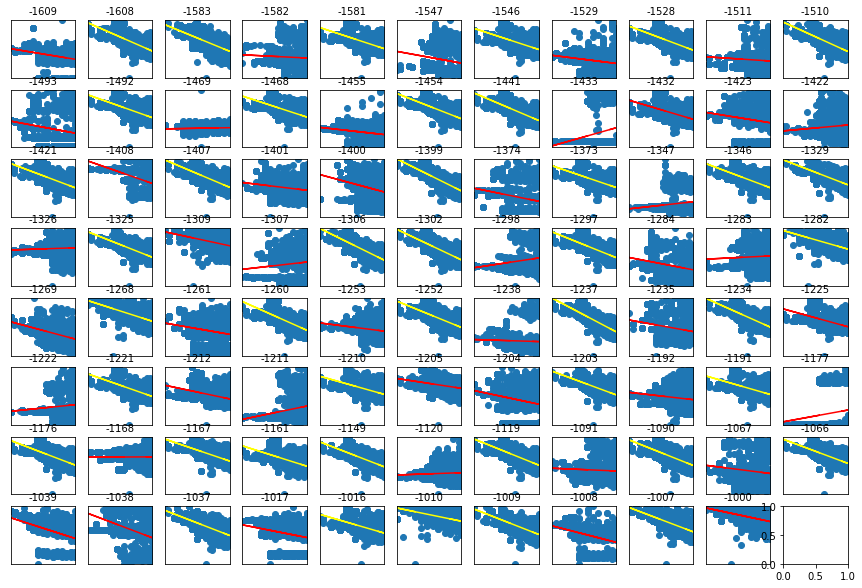

In [38]:
servicepoint_list=single_Famiy['Service Point'].unique()[:]
ncol=11
nrow=8
fig, axes = plt.subplots(nrow,ncol,figsize=(15,10))
i=0
count_good_servicepoints=0
count_bad_servicepoints=0
for r in range(nrow):
    for c in range(ncol):
        if i<len(servicepoint_list):
            result=prediction_model(servicepoint_list[i],corr_threshold=0.3,r2_threshold=0.3,row_index=r,col_index=c, 
                     visualize=True,calculate_metrics=None, metric=None,boostrap=True)
            if result in ["data and model not good","data not good but model is good",
                         "data good,but model not good"]:
                count_bad_servicepoints+=1
            elif result=="data and model both good":
                count_good_servicepoints+=1
        i+=1
print('good_points',count_good_servicepoints)
print('bad_points',count_bad_servicepoints)
print('bad points%',count_bad_servicepoints/length)
print('good points%',count_good_servicepoints/length)

            

In [41]:
good=[]
for j in single_Famiy['zipCode'].unique():
    servicepoint_list=single_Famiy[single_Famiy['zipCode']==j]['Service Point'].unique()
    length=len(servicepoint_list)
    ncol=11
    nrow=8
    #fig, axes = plt.subplots(nrow,ncol,figsize=(15,10))
    i=0
    count_good_servicepoints=0
    count_bad_servicepoints=0
    for r in range(nrow):
        for c in range(ncol):
            if i<len(servicepoint_list):
                result=prediction_model(servicepoint_list[i],corr_threshold=0.3,r2_threshold=0.3,row_index=r,col_index=c, 
                         visualize=False,calculate_metrics=None, metric=None,boostrap=True)
                if result in ["data and model not good","data not good but model is good",
                             "data good,but model not good"]:
                    count_bad_servicepoints+=1
                elif result=="data and model both good":
                    count_good_servicepoints+=1
            i+=1
    print(j,length,count_good_servicepoints/length)
    if count_good_servicepoints/length==1.0:
        good.append(j)
        
    """print('good_points',count_good_servicepoints)
    print('bad_points',count_bad_servicepoints)
    print('bad points%',count_bad_servicepoints/length)
    print('good points%',count_good_servicepoints/length)"""

78759 2 0.5
78758 3 0.6666666666666666
78757 2 0.5
78756 2 0.5
78754 2 0.5
78753 2 0.5
78752 2 0.5
78751 2 0.5
78750 1 1.0
78749 2 0.0
78748 3 0.3333333333333333
78747 2 0.5
78746 3 0.3333333333333333
78745 2 0.5
78744 2 0.5
78742 1 1.0
78741 2 0.5
78739 1 0.0
78738 2 0.5
78736 1 1.0
78735 2 0.5
78734 3 0.3333333333333333
78733 2 0.5
78732 2 0.5
78731 2 0.5
78730 2 0.5
78729 2 0.5
78728 1 0.0
78727 2 0.5
78726 1 0.0
78725 2 0.5
78724 3 0.3333333333333333
78723 2 0.5
78722 2 0.5
78721 2 0.5
78717 1 1.0
78705 1 1.0
78704 2 0.5
78703 2 0.5
78702 2 0.5
78701 3 0.3333333333333333
78660 2 0.5
78653 1 1.0
78652 1 1.0
78617 2 0.5
78610 1 0.0


In [34]:
good

[78750, 78742]

good_points 1
bad_points 0
bad points% 0.0
good points% 0.5


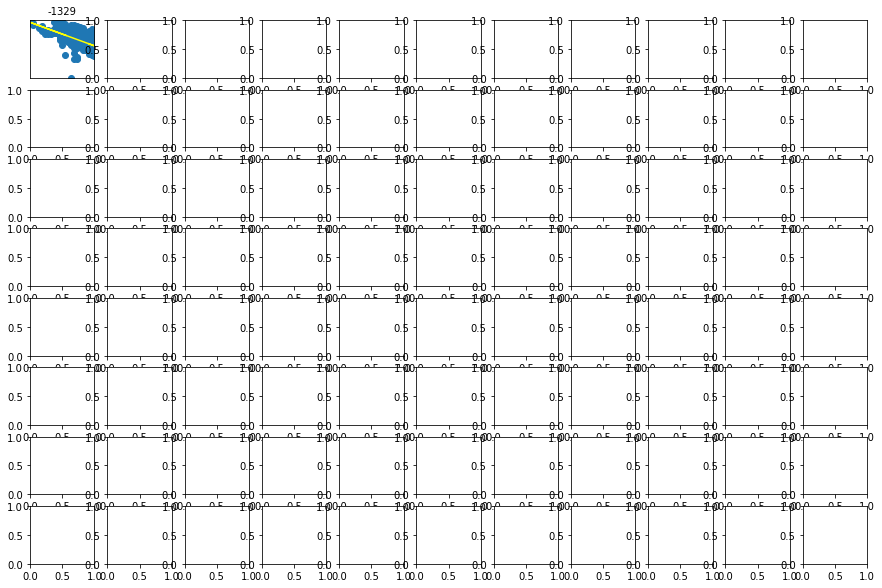

In [36]:
servicepoint_list=single_Famiy[single_Famiy['zipCode']==78742]['Service Point'].unique()
ncol=11
nrow=8
fig, axes = plt.subplots(nrow,ncol,figsize=(15,10))
i=0
count_good_servicepoints=0
count_bad_servicepoints=0
for r in range(nrow):
    for c in range(ncol):
        if i<len(servicepoint_list):
            result=prediction_model(servicepoint_list[i],corr_threshold=0.3,r2_threshold=0.3,row_index=r,col_index=c, 
                     visualize=True,calculate_metrics=None, metric=None,boostrap=False)
            if result in ["data and model not good","data not good but model is good",
                         "data good,but model not good"]:
                count_bad_servicepoints+=1
            elif result=="data and model both good":
                count_good_servicepoints+=1
        i+=1
print('good_points',count_good_servicepoints)
print('bad_points',count_bad_servicepoints)
print('bad points%',count_bad_servicepoints/length)
print('good points%',count_good_servicepoints/length)

In [ ]:
s=prediction_model(-1581,visualize=False,calculate_metrics=True,metric='perc_diff')
s1=prediction_model(-1582,visualize=False,calculate_metrics=True,metric='perc_diff')
s2=prediction_model(-1583,visualize=False,calculate_metrics=True,metric='perc_diff')
combined_df=s1.merge(s,left_index=True,right_index=True).merge(s2,left_index=True,right_index=True).T
combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
combined_df


In [ ]:
"""servicepoint=-1582
q=prediction_model(-1581,visualize=False,calculate_metrics=False,metric=None)
q['is_outage']=0
Q1=a1.quantile(0.25)
Q3=a1.quantile(0.75)
IQR=Q3-Q1
th=Q1-1.5*IQR
q.loc[q["Energy_kwh"] <th, "is_outage"] = 1
q1=q.rename(columns={'is_outage':servicepoint})[[servicepoint]]
q"""

In [ ]:
#a=detect_outage(-1583)
#a1=detect_outage(-1582)
#a2=detect_outage(-1581)
"""combined_a=a1.merge(a,left_index=True,right_index=True).merge(a2,left_index=True,right_index=True).T
combined_a.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
combined_a"""

In [ ]:

combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
combined_df

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))
sns.heatmap(combined_df,vmin=-100,vmax=100,cmap='RdBu_r',ax=ax1,linewidths = 1,annot=np.array(combined_a),linecolor='black')
degrees = 0
plt.yticks(rotation=degrees)
plt.xticks(rotation=degrees)
plt.xlabel('date')
plt.ylabel('servicepoint')


In [ ]:
s=function(-1583,'perc_diff(reverse)')
s1=function(-1582,'perc_diff(reverse)')
s2=function_1581(-1581,'perc_diff(reverse)')
combined_df=s1.merge(s,left_index=True,right_index=True).merge(s2,left_index=True,right_index=True).T
combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
fig, ax1 = plt.subplots(figsize=(15,5))
sns.heatmap(combined_df,vmax=100,vmin=-100,cmap='RdBu_r',ax=ax1,linewidths = 1,annot=np.array(combined_a),linecolor='black')
degrees = 0
plt.yticks(rotation=degrees)
plt.xticks(rotation=degrees)
plt.xlabel('date')
plt.ylabel('servicepoint')


In [ ]:
s=function(-1583,'difference(z_score)')
s1=function(-1582,'difference(z_score)')
s2=function_1581(-1581,'difference(z_score)')
combined_df=s1.merge(s,left_index=True,right_index=True).merge(s2,left_index=True,right_index=True).T
combined_df.columns=['11th','12th','13th','14th','15th','16th','17th','18th','19th']
fig, ax1 = plt.subplots(figsize=(15,5))
sns.heatmap(combined_df,vmin=-3,vmax=3,cmap='RdBu_r',ax=ax1,linewidths = 1,annot=np.array(combined_a),linecolor='black')
degrees = 0
plt.yticks(rotation=degrees)
plt.xticks(rotation=degrees)
plt.xlabel('date')
plt.ylabel('servicepoint')